In [1]:
# package importing

import cupy as cp
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

# for getContour function 
import cv2

## Scaling Parameters

In [2]:
width, height, distance, xShift, yShift = cp.float64(0), cp.float64(0), cp.float64(0), cp.float64(0), cp.float64(0)

def setScale(*args):
    # physical size in um: width, height, distance (positive if sample at +z)
    global width, height, distance, xShift, yShift

    if len(args)==3:
        width, height, distance = cp.float64(args[0]), cp.float64(args[1]), cp.float64(args[2])
    elif len(args)==5:
        width, height, distance, xShift, yShift = cp.float64(args[0]), cp.float64(args[1]), cp.float64(args[2]), cp.float64(args[3]), cp.float64(args[4])
    else:
        width = cp.float64(input('physical size: width:\t'))
        height = cp.float64(input('physical size: height:\t'))
        distance = cp.float64(input('physical size: distance:\t'))
        xShift = cp.float64(input('physical size: xShift:\t'))
        yShift = cp.float64(input('physical size: yShift:\t'))
    
    return None

In [3]:
setScale(280,175,27,18,1.5)

## Loading B Field Data

In [4]:
bExp = cp.zeros(shape=(1,1,1),dtype=cp.float64)
bPixelX, bPixelY = 1,1

def loadB():
    # loading magnetic field data (in .npy format)
    global bExp, bPixelX, bPixelY

    root = tk.Tk()
    bX = np.load(filedialog.askopenfilename(title="Select Bx Data (in .npy format)"))
    root.withdraw()
    bPixelX, bPixelY = bX.shape

    root = tk.Tk()
    root.withdraw()
    bY = np.load(filedialog.askopenfilename(title="Select By Data (in .npy format)"))

    root = tk.Tk()
    root.withdraw()
    bZ = np.load(filedialog.askopenfilename(title="Select Bz Data (in .npy format)"))

    bExp = cp.asarray(np.concatenate((bX[:,:,np.newaxis],bY[:,:,np.newaxis],bZ[:,:,np.newaxis]),axis=2))

    return None

In [5]:
loadB()

## Selecting B Region of Interest

In [6]:
def bShow(bMap):

    plt.cla()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    bRMSFull = np.sqrt(cp.sum(bMap**2)/bPixelX/bPixelY/3)
    HB = min(2*bRMSFull, cp.max(bMap))
    LB = max(-2*bRMSFull,cp.min(bMap))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imx = axs[0].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0].set_title('Bx')
    imy = axs[1].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1].set_title('By')
    imz = axs[2].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[2].set_title('Bz')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
        
    xTicks, xTickLabels = makeXTicks(bPixelX)
    yTicks, yTickLabels = makeYTicks(bPixelY)

    for i in range(3):
        axs[i].set_xticks(xTicks)
        axs[i].set_yticks(yTicks)
        axs[i].set_xticklabels(xTickLabels)
        axs[i].set_yticklabels(yTickLabels)
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')

    return None

In [7]:
bStartX, bStartY, bEndX, bEndY, bCropX, bCropY = 0,0,1,1,1,1
bRMS = 1
bCropped = cp.zeros(shape=(bCropX,bCropY,3),dtype=cp.float64)

def bCropping(ifBalanced=False):
    # selecting region of interest
    global bStartX, bStartY, bEndX, bEndY, bCropX, bCropY, bRMS, bCropped

    bShow(bExp)
    plt.savefig('bShow.png', format='png')

    root = tk.Tk()
    root.title("Selecting B Region")

    canvas = tk.Canvas(root)
    image = tk.PhotoImage(master=canvas, file='bShow.png')
    image_label = tk.Label(root, image=image)
    image_label.image = image
    image_label.pack()

    label_start_x = tk.Label(root, text="StartX=")
    label_start_x.pack()

    entry_start_x = tk.Entry(root)
    entry_start_x.pack()

    label_start_y = tk.Label(root, text="StartY=")
    label_start_y.pack()

    entry_start_y = tk.Entry(root)
    entry_start_y.pack()

    label_end_x = tk.Label(root, text="EndX=")
    label_end_x.pack()

    entry_end_x = tk.Entry(root)
    entry_end_x.pack()

    label_end_y = tk.Label(root, text="EndY=")
    label_end_y.pack()

    entry_end_y = tk.Entry(root)
    entry_end_y.pack()

    def on_enter_button_clicked():
        # Get values from entry widgets, remain unchanged if empty
        global bStartX, bStartY, bEndX, bEndY, bCropX, bCropY, bRMS, bCropped
        bStartX = int(entry_start_x.get()) if entry_start_x.get() != '' else bStartX
        bStartY = int(entry_start_y.get()) if entry_start_y.get() != '' else bStartY
        bEndX = int(entry_end_x.get()) if entry_end_x.get() != '' else bEndX
        bEndY = int(entry_end_y.get()) if entry_end_y.get() != '' else bEndY
        bCropX = bEndX - bStartX
        bCropY = bEndY - bStartY
        bCropped = bExp[bStartX:bEndX,bStartY:bEndY,:]
        if ifBalanced:
            bAVG = cp.sum(bCropped) / bCropX / bCropY
            bCropped -= bAVG
        bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
        
        root.destroy()
        root.quit()

        print(f"StartX={bStartX}, StartY={bStartY}, EndX={bEndX}, EndY={bEndY}")
        return None
    
    def on_cancel_button_clicked():
        root.destroy()
        root.quit()
        return None

    button_enter = tk.Button(root, text="Enter", command=on_enter_button_clicked)
    button_enter.pack()
    button_cancel = tk.Button(root, text="Cancel", command=on_cancel_button_clicked)
    button_cancel.pack()

    root.mainloop()

    os.remove('bShow.png')
    
    return None

StartX=200, StartY=100, EndX=210, EndY=110


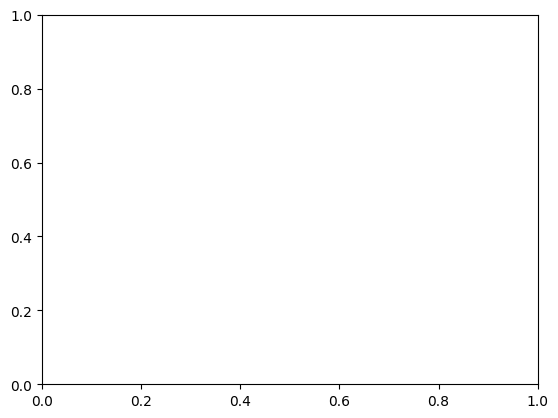

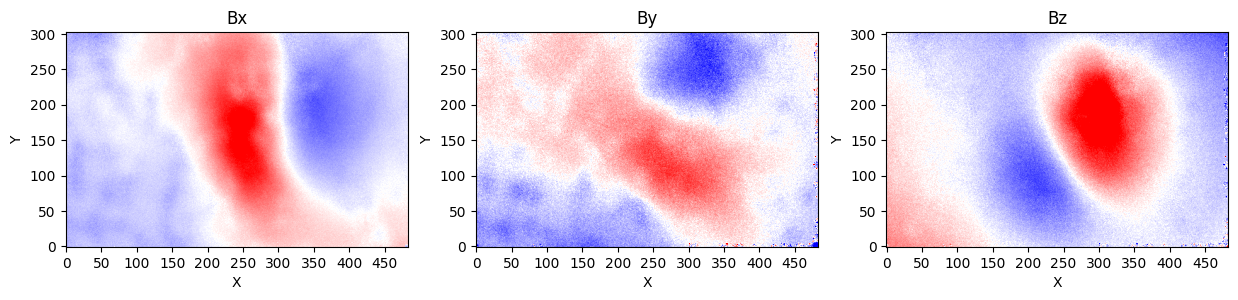

In [8]:
bCropping()

## Selecting Magnetization Region

In [9]:
mPixelX, mPixelY, NofP, listX, listY, mRes = 1,1,1,[0],[0],cp.zeros(shape=(1,3),dtype=cp.float64)
mAVG = 1

def spinAllocate(magFactor=1):
    global mPixelX, mPixelY, NofP, listX, listY, mRes, mAVG

    root = tk.Tk()
    image_path = filedialog.askopenfilename(title="Select camera image")
    root.withdraw()
    img_ = cv2.imread(image_path)  # The image should be larger than img_w * img_h
    mPixelY, mPixelX = img_.shape[0:2] # Original image height and width
    cv2.destroyAllWindows()
    
    def main():
        global all_polygons, current_polygon, img, img_copy
        all_polygons = []
        current_polygon = []
        def draw_polygons(event, x, y, flags, param):
            global all_polygons, current_polygon, img, img_copy
            if event == cv2.EVENT_LBUTTONDOWN:  # 左键点击
                current_polygon.append((x, y))
                cv2.circle(img, (x, y), 2, (0, 255, 0), -1)
                if len(current_polygon) > 1:
                    cv2.line(img, current_polygon[-2], current_polygon[-1], (255, 0, 0), 2)
                cv2.imshow('image', img)
            elif event == cv2.EVENT_RBUTTONDOWN:  # 右键点击结束当前多边形绘制
                if len(current_polygon) > 2:
                    cv2.line(img, current_polygon[-1], current_polygon[0], (255, 0, 0), 2)
                    all_polygons.append(current_polygon.copy())
                    current_polygon = []
                    img = img_copy.copy()
                    for polygon in all_polygons:
                        for i in range(len(polygon)):
                            cv2.circle(img, polygon[i], 2, (0, 255, 0), -1)
                            cv2.line(img, polygon[i], polygon[(i + 1) % len(polygon)], (255, 0, 0), 2)
                    cv2.imshow('image', img)
            return None
        def get_polygon_mask(img_shape, polygons):
            mask = np.zeros(img_shape[:2], dtype=np.uint8)
            for vertices in polygons:
                vertices = np.array([vertices], dtype=np.int32)
                cv2.fillPoly(mask, vertices, 1)
            return mask
        def get_pixels_within_polygons(img, polygons):
            mask = get_polygon_mask(img.shape, polygons)
            points = np.column_stack(np.where(mask == 1))
            return points
        
        img = cv2.imread(image_path)
        # 检查图像是否成功加载
        if img is None:
            print(f'Failed to load image: {image_path}')
            return
        
        img_copy = img.copy()
        cv2.namedWindow('image')
        cv2.setMouseCallback('image', draw_polygons)
        cv2.imshow('image', img)

        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break

        cv2.destroyAllWindows()
        if all_polygons:
            return get_pixels_within_polygons(img, all_polygons)

    selected = main()
    listX, listY = [],[]
    selected_N = list(set((round((y+0.5)*magFactor-0.5),round((mPixelY-1-x+0.5)*magFactor-0.5)) for x,y in selected))
    mPixelX, mPixelY = int(magFactor*mPixelX), int(magFactor*mPixelY)
    NofP = len(selected_N)
    for i in range(NofP):
        listX.append(selected_N[i][0])
        listY.append(selected_N[i][1])
    mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

    return None


In [11]:
spinAllocate(0.25)

## Generating Coefficient Matrix

In [38]:
matrixA = cp.zeros(shape=(bCropX,bCropY,NofP,3,3),dtype=cp.float64)

def matrixAGenerate(ifTimer=True):
    global matrixA
    
    timeStart = time()
    
    rPosition = np.zeros((bCropX,bCropY,NofP,3),dtype = cp.float64)
    for i in range(bCropX):
        for j in range(bCropY):
            for k in range(NofP):
                bX = (bStartX+i+0.5) * width / bPixelX
                bY = (bStartY+j+0.5) * height / bPixelY
                mX = (listX[k]+0.5) * width / mPixelX - xShift
                mY = (listY[k]+0.5) * height / mPixelY - yShift
                rPosition[i,j,k,0] = bX - mX
                rPosition[i,j,k,1] = bY - mY
                rPosition[i,j,k,2] = np.sqrt(rPosition[i,j,k,0]**2 + rPosition[i,j,k,1]**2 + distance**2)
    
    matrixAnp = np.zeros(shape=(bCropX,bCropY,NofP,3,3),dtype=cp.float64)
    for i in range(bCropX):
        for j in range(bCropY):
            for k in range(NofP):
                matrixAnp[i,j,k,0,0] = 3*rPosition[i,j,k,0]*rPosition[i,j,k,0]/rPosition[i,j,k,2]**5 -\
                                                1/rPosition[i,j,k,2]**3
                matrixAnp[i,j,k,0,1] = 3*rPosition[i,j,k,0]*rPosition[i,j,k,1]/rPosition[i,j,k,2]**5
                matrixAnp[i,j,k,0,2] = -3*rPosition[i,j,k,0]*distance/rPosition[i,j,k,2]**5
                matrixAnp[i,j,k,1,0] = matrixAnp[i,j,k,0,1]
                matrixAnp[i,j,k,1,1] = 3*rPosition[i,j,k,1]*rPosition[i,j,k,1]/rPosition[i,j,k,2]**5 -\
                                                1/rPosition[i,j,k,2]**3
                matrixAnp[i,j,k,1,2] = -3*rPosition[i,j,k,1]*distance/rPosition[i,j,k,2]**5
                matrixAnp[i,j,k,2,0] = matrixAnp[i,j,k,0,2]
                matrixAnp[i,j,k,2,1] = matrixAnp[i,j,k,1,2]
                matrixAnp[i,j,k,2,2] = 3*distance*distance/rPosition[i,j,k,2]**5 - 1/rPosition[i,j,k,2]**3

    matrixA = cp.asarray(matrixAnp)
    del rPosition, matrixAnp

    timeStop = time()

    if ifTimer:
        print('generate coefficient time:\t%s'%(timeStop-timeStart))

    return None

In [39]:
matrixAGenerate()

generate coefficient time:	0.0679481029510498


## Loss Function

In [14]:
def lossF(mMap,alpha=0,beta=0):
    
    bRes = cp.tensordot(matrixA,mMap,axes=([2,4],[0,1]))
    errTerm = cp.sum((bRes - bCropped) ** 2)
    del bRes

    if alpha != 0:
        mRes_ = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResXp = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResXm = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResYp = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResYm = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        for i in range(NofP):
            mRes_[listX[i],listY[i],:] = mMap[i,:]
            mResXp[(listX[i]+1)%mPixelX,listY[i],:] = mMap[i,:]
            mResXm[(listX[i]-1)%mPixelX,listY[i],:] = mMap[i,:]
            mResYp[listX[i],(listY[i]+1)%mPixelY,:] = mMap[i,:]
            mResYm[listX[i],(listY[i]-1)%mPixelY,:] = mMap[i,:]
        gradTermXp = cp.sum((mRes_ - mResXp) ** 2)
        gradTermXm = cp.sum((mRes_ - mResXm) ** 2)
        gradTermYp = cp.sum((mRes_ - mResYp) ** 2)
        gradTermYm = cp.sum((mRes_ - mResYm) ** 2)
        gradTerm = (gradTermXp+gradTermXm+gradTermYp+gradTermYm)/4
    else:
        gradTerm = 0

    if beta != 0:
        ampTerm = cp.sum(mMap**2)
    else:
        ampTerm = 0

    return errTerm / bRMS**2 / bCropX / bCropY / 3 + (beta * ampTerm + alpha * gradTerm) / mAVG**2 / NofP

## Optimization Function Pool

In [15]:
def noise(mMap, strg=0.01):
    return mMap + strg * mAVG * cp.random.uniform(-1,1,size=mMap.shape)

def stretch(mMap, diff=0):
    return cp.float64(1+diff) * mMap

In [16]:
def step(mMap, rate=0, alpha=0, beta=0, dist=0.02):
    dirc_ = cp.random.choice([-1,-1,-1,-1,1,1,1,1,1],size=mMap.shape)
    decay_ = dist * mAVG
    delta_ = decay_ * dirc_

    vp = lossF(mMap + delta_, alpha, beta)
    vm = lossF(mMap - delta_, alpha, beta)
    v_ = lossF(mMap, alpha, beta)
    F_ = (vp - vm) / 2 / dist
    F__ = (vp + vm - 2*v_) / dist**2

    return mMap - (1+rate) * F_/F__ * mAVG * dirc_

## Result Plotting

In [17]:
def showM():
    
    mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
    for i in range(NofP):
        mMat[listX[i],listY[i],:] = mRes[i,:]

    plt.cla()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    mRMSFull = np.sqrt(cp.sum(mRes**2)/NofP/3)
    HB = min(2*mRMSFull, cp.max(mRes))
    LB = max(-2*mRMSFull,cp.min(mRes))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imx = axs[0].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0].set_title('Mx')
    imy = axs[1].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1].set_title('My')
    imz = axs[2].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[2].set_title('Mz')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
    
    xTicks, xTickLabels = makeXTicks(mPixelX)
    yTicks, yTickLabels = makeYTicks(mPixelY)

    for i in range(3):
        axs[i].set_xticks(xTicks)
        axs[i].set_yticks(yTicks)
        axs[i].set_xticklabels(xTickLabels)
        axs[i].set_yticklabels(yTickLabels)
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')

    plt.show()

    return None

def showB():
    
    bRes = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))

    plt.cla()

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    
    bRMSCropped = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
    HB = min(2*bRMSCropped, cp.max(bCropped))
    LB = max(-2*bRMSCropped,cp.min(bCropped))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imxr = axs[0][0].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][0].set_title('Bx Reconstructed')
    imyr = axs[0][1].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][1].set_title('By Reconstructed')
    imzr = axs[0][2].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][2].set_title('Bz Reconstructed')

    imx = axs[1][0].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][0].set_title('Bx Experiment')
    imy = axs[1][1].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][1].set_title('By Experiment')
    imz = axs[1][2].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][2].set_title('Bz Experiment')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
        
    xTicks, xTickLabels = makeXTicks(bCropX)
    yTicks, yTickLabels = makeYTicks(bCropY)

    for i in range(6):
        axs[i//3][i%3].set_xticks(xTicks)
        axs[i//3][i%3].set_yticks(yTicks)
        axs[i//3][i%3].set_xticklabels(xTickLabels)
        axs[i//3][i%3].set_yticklabels(yTickLabels)
        axs[i//3][i%3].set_xlabel('X')
        axs[i//3][i%3].set_ylabel('Y')

    plt.show()

    return None

## Parameter Optimization

In [40]:
def optPar(d=None, x=None, y=None, alpha=0, beta=0, iterRound=2000, optRound=20, filename=None, ifTimer=True):
    global distance, xShift, yShift, matrixA, mAVG

    dCOPY = distance
    xCOPY, yCOPY = xShift, yShift
    if filename:
        cp.save(filename,matrixA)
    mCOPY = mAVG

    d_ = d if d else distance
    xShift_ = x if x else xShift
    yShift_ = y if y else yShift

    for i_ in range(optRound):
        timeStart = time()
        delta_ = cp.float64(0.01)*cp.random.choice([-1,-1,-1,-1,1,1,1,1,1],size=3,)
        if d==None:
            delta_[0]=0
        if x==None:
            delta_[1]=0
        if y==None:
            delta_[2]=0
        
        pl = (delta_+1)
        distance, xShift, yShift = d_*pl[0], xShift_*pl[1], yShift_*pl[2]
        matrixAGenerate(False)
        timeTemp = time()
        if i_==0:
            print('first generation time:\t%s'%(timeTemp-timeStart))
        mRes_ = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for j_ in range(iterRound):
            mRes_ = step(mRes_,alpha=alpha, beta=beta)
        vp = lossF(mRes_)
        timeTemp = time()
        if i_==0:
            print('first step time:\t%s'%(timeTemp-timeStart))

        distance, xShift, yShift = d_, xShift_, yShift_
        matrixAGenerate(False)
        mRes_ = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for j_ in range(iterRound):
            mRes_ = step(mRes_,alpha=alpha, beta=beta)
        v_ = lossF(mRes_)

        pl = (1-delta_)
        distance, xShift, yShift = d_*pl[0], xShift_*pl[1], yShift_*pl[2]
        matrixAGenerate(False)
        mRes_ = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for j_ in range(iterRound):
            mRes_ = step(mRes_,alpha=alpha, beta=beta)
        vm = lossF(mRes_)  
        timeTemp = time()
        if i_==0:
            print('first optimization time:\t%s'%(timeTemp-timeStart))
        
        F_ = (vp - vm) / 2 / 0.01
        F__ = (vp + vm - 2*v_) / 0.01**2

        pl = 1 - F_/F__ / 0.01 * delta_
        d_, xShift_, yShift_ = d_*pl[0], xShift_*pl[1], yShift_*pl[2]

        timeStop = time()
        if ifTimer:
            print('round %s time:\t%s'%(i_, timeStop-timeStart))
    
    distance, xShift, yShift =  d_, xShift_, yShift_
    matrixAGenerate(False)
    mRes_ = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
    for j_ in range(iterRound):
        mRes_ = step(mRes_,alpha=alpha, beta=beta)
    v_ = lossF(mRes_)
    
    distance, xShift, yShift = dCOPY, xCOPY, yCOPY
    mAVG = mCOPY
    if filename:    
        matrixA = cp.load(filename)
        os.remove(filename)

    return d_, xShift_, yShift_, v_


In [41]:
matrixAGenerate()

generate coefficient time:	0.06351399421691895


In [42]:
print(optPar(d=27, x=18, y=1.5, alpha=7, beta=9, iterRound=100, optRound=1))

first generation time:	7.753930568695068
first step time:	9.680939197540283
first optimization time:	21.401803970336914
round 0 time:	21.401803970336914
(array(26.74620598), array(17.83080399), array(1.51409967), array(0.70697956))


In [43]:
matrixAGenerate()

generate coefficient time:	0.06999635696411133


In [37]:
matrixA=matrixAGenerate(False)

In [ ]:
# distance, xShift, yShift = cp.float64(27), cp.float64(17), cp.float64(1.5)
# mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
#matrixA = cp.load('A.npy')

In [ ]:
#mRes=cp.concatenate((cp.ones(shape=(NofP,1),dtype=cp.float64),cp.ones(shape=(NofP,1),dtype=cp.float64),cp.ones(shape=(NofP,1),dtype=cp.float64)*0.2),axis=1)
#mRes=cp.zeros(shape=(NofP,3),dtype=cp.float64)

In [ ]:
#bCropped=cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
#bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
#mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

In [ ]:
lossF(mRes)

In [ ]:
for i in range(2000):
    mRes = step(mRes,alpha=8,beta=8)
print(lossF(mRes))

In [ ]:
for i in range(2000):
    mRes = step(mRes,alpha=1.2,beta=1.5)
print(lossF(mRes))

In [ ]:
for i in range(20000):
    mRes = step(mRes,beta=0.6)
print(lossF(mRes))

In [ ]:
for i in range(2000):
    mRes = step(mRes,alpha=0.6)
print(lossF(mRes))

In [ ]:
for i in range(20000):
    mRes = step(mRes,alpha=1,beta=0.4)
print(lossF(mRes))

In [ ]:
for i in range(40000):
    mRes = step(mRes,beta=1)
print(lossF(mRes))

In [ ]:
for i in range(5000):
    mRes = step(mRes,alpha=0.2,beta=0.2)
print(lossF(mRes))

In [ ]:
showM(mRes)

In [ ]:
showB(bCropped)

In [ ]:
xavg=cp.sum(mRes[:,0])/NofP
yavg=cp.sum(mRes[:,1])/NofP
zavg=cp.sum(mRes[:,2])/NofP
print(xavg,yavg,zavg)
mRes_=cp.concatenate((xavg*cp.ones(shape=(NofP,1),dtype=cp.float64),yavg*cp.ones(shape=(NofP,1),dtype=cp.float64),zavg*cp.ones(shape=(NofP,1),dtype=cp.float64)),axis=1)

In [ ]:
bCropped_=cp.tensordot(matrixA,mRes_,axes=([2,4],[0,1]))

In [ ]:
showM(mRes_)

In [ ]:
showB(bCropped_)